In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re
%matplotlib inline

!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer

!pip install wordcloud
from wordcloud import WordCloud

!pip install tweet-preprocessor
import preprocessor as p

from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [2]:
encoding = 'ISO-8859-1'
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']

dataset = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding=encoding, names=col_names)

In [3]:
dataset.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df = dataset.copy().sample(8000, random_state=42)
df["label"] = 0
df = df[['text', 'label']]
df.dropna(inplace=True)
df.head()

,text,label
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,0
750,"@misstoriblack cool , i have no tweet apps fo...",0
766711,@TiannaChaos i know just family drama. its la...,0
285055,School email won't open and I have geography ...,0
705995,upper airways problem,0


In [5]:
col_names = ['id', 'text']
df2 = pd.read_csv(os.path.join('depressive_tweets_processed.csv'),sep = '|', header = None, usecols = [0,5], nrows = 3200, names=col_names)

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2345 non-null   object
 1   text    2313 non-null   object
dtypes: object(2)
memory usage: 36.8+ KB


In [7]:
# add `label` colum with value 1's
df2['label'] = 1
df2 = df2[['text', 'label']]

In [8]:
df = pd.concat([df,df2]) # merge the dataset on normal tweets and depressive tweets
df = df.sample(frac=1)  # shuffle the dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10345 entries, 1991 to 896602
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10313 non-null  object
 1   label   10345 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 242.5+ KB


In [10]:
contractions = pd.read_json('contraction.json', typ='series')
contractions = contractions.to_dict()

In [11]:
c_re = re.compile('(%s)' % '|'.join(contractions.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return contractions[match.group(0)]
    return c_re.sub(replace, text)

In [12]:
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        tweet = tweet.lower()
        tweet = BAD_SYMBOLS_RE.sub(' ', tweet)
        tweet = p.clean(tweet)
        
        #expand contraction
        tweet = expandContractions(tweet)

        #remove punctuation
        tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

        #stop words
        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        tweet = ' '.join(filtered_sentence)
        
        cleaned_tweets.append(tweet)
        
    return cleaned_tweets

In [13]:
X = clean_tweets([tweet for tweet in df['text']])

# Analysis of Word

In [14]:
depressive_tweets = [clean_tweets([t for t in df2['text']])]
depressive_words = ' '.join(list(map(str, depressive_tweets)))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)

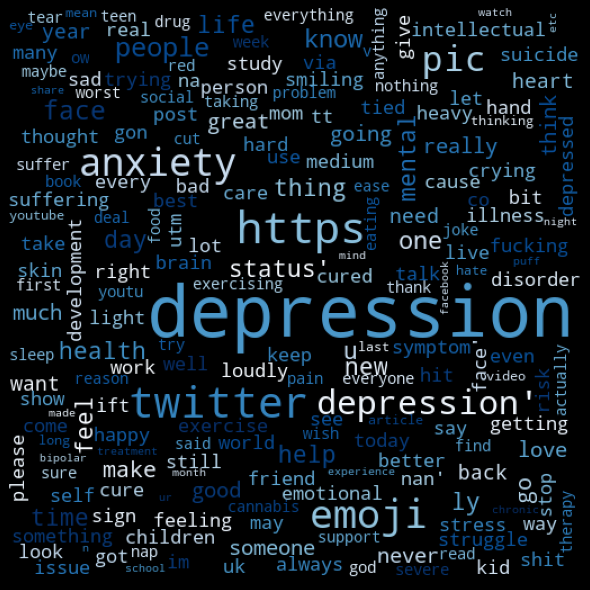

In [15]:
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# Tokenization

In [16]:
from keras.preprocessing.text import Tokenizer
MAX_NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

In [17]:
word_vector = tokenizer.texts_to_sequences(X)

In [18]:
word_index = tokenizer.word_index

In [19]:
vocab_size = len(word_index)
vocab_size   # num of unique tokens

20670

In [20]:
MAX_SEQ_LENGTH = 140
input_tensor = pad_sequences(word_vector, maxlen=MAX_SEQ_LENGTH)

In [21]:
input_tensor.shape

(10345, 140)

*TF-IDF Classifier*

In [22]:
corpus = df['text'].values.astype('U')
tfidf = TfidfVectorizer(max_features = MAX_NUM_WORDS) 
tdidf_tensor = tfidf.fit_transform(corpus)

In [23]:
tdidf_tensor.shape

(10345, 10000)

# Training

In [24]:
x_train, x_test, y_train, y_test = train_test_split(tdidf_tensor, df['label'].values, test_size=0.3)

In [25]:
baseline_model = SVC()
baseline_model.fit(x_train, y_train)

SVC()

In [26]:
predictions = baseline_model.predict(x_test)

In [27]:
accuracy_score(y_test, predictions)

0.9967783505154639

In [28]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.99629   0.99959   0.99794      2418
           1    0.99853   0.98688   0.99267       686

    accuracy                        0.99678      3104
   macro avg    0.99741   0.99323   0.99530      3104
weighted avg    0.99678   0.99678   0.99677      3104



# LSTM Model for more accuracy

## Word Embedding

In [29]:
EMBEDDING_FILE = ('GoogleNews-vectors-negative300.bin.gz')
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [30]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

In [31]:
for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NUM_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [32]:
inp = Input(shape=(MAX_SEQ_LENGTH,))
x = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)

In [33]:
# Compile the model
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(input_tensor, df['label'].values, test_size=0.3)

In [35]:
model.fit(x_train, y_train, batch_size=16, epochs=10)

Epoch 1/10
453/453 [==============================] - 352s 777ms/step - loss: 0.0717 - accuracy: 0.9776
Epoch 2/10
453/453 [==============================] - 371s 819ms/step - loss: 0.0119 - accuracy: 0.9965
Epoch 3/10
453/453 [==============================] - 303s 669ms/step - loss: 0.0045 - accuracy: 0.9988
Epoch 4/10
453/453 [==============================] - 331s 732ms/step - loss: 0.0053 - accuracy: 0.9985
Epoch 5/10
453/453 [==============================] - 362s 800ms/step - loss: 0.0044 - accuracy: 0.9988
Epoch 6/10
453/453 [==============================] - 348s 768ms/step - loss: 0.0028 - accuracy: 0.9993
Epoch 7/10
453/453 [==============================] - 327s 722ms/step - loss: 0.0020 - accuracy: 0.9994
Epoch 8/10
453/453 [==============================] - 325s 717ms/step - loss: 0.0023 - accuracy: 0.9993
Epoch 9/10
453/453 [==============================] - 342s 755ms/step - loss: 0.0046 - accuracy: 0.9989
Epoch 10/10
453/453 [==============================] - 341s 753m

In [43]:
preds = model.predict(x_test)

In [44]:
preds  = np.round(preds.flatten())
print(classification_report(y_test, preds, digits=5))

              precision    recall  f1-score   support

           0    0.99293   0.99749   0.99520      2392
           1    0.99144   0.97612   0.98372       712

    accuracy                        0.99259      3104
   macro avg    0.99218   0.98681   0.98946      3104
weighted avg    0.99258   0.99259   0.99257      3104



# Naive Baye's

In [45]:
x_train, x_test, y_train, y_test = train_test_split(X, df.label, test_size=0.3, random_state = 42)

In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())])
nb.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [47]:
y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.9023840206185567
              precision    recall  f1-score   support

           0    0.88757   1.00000   0.94044      2392
           1    1.00000   0.57444   0.72971       712

    accuracy                        0.90238      3104
   macro avg    0.94378   0.78722   0.83507      3104
weighted avg    0.91336   0.90238   0.89210      3104



# Linear Support Vector

In [48]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [49]:
y_pred = sgd.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.9845360824742269
              precision    recall  f1-score   support

           0    0.98033   1.00000   0.99007      2392
           1    1.00000   0.93258   0.96512       712

    accuracy                        0.98454      3104
   macro avg    0.99016   0.96629   0.97759      3104
weighted avg    0.98484   0.98454   0.98434      3104



# Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5))])

logreg.fit(x_train, y_train)

AttributeError: 'str' object has no attribute 'decode'

In [ ]:
y_pred = logreg.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, digits=5))